# 1. Preprocess

Reference:
- https://www.kaggle.com/aakashnain/firstlook
- https://www.kaggle.com/the1owl/the-autonomy-of-robots
- https://www.kaggle.com/jpmiller/cvpr-eda-with-faster-labeling
- https://www.kaggle.com/andrewrib/recovering-the-videos

## Import PKGs

In [1]:
import time
import os
import json
import csv
import zipfile
import pickle
from skimage.io import imread
from PIL import Image
import shutil


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from IPython.display import display

from tqdm import tqdm
from multiprocessing import cpu_count

from sklearn.metrics import confusion_matrix, accuracy_score

## Run name

In [2]:
project_name = 'cvpr2018_driving'
step_name = 'Preprocess'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

run_name: cvpr2018_driving_Preprocess_20180415_145045


## Project folders

In [3]:
cwd = os.getcwd()
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')
feature_folder = os.path.join(cwd, 'feature')
post_pca_feature_folder = os.path.join(cwd, 'post_pca_feature')
log_folder = os.path.join(cwd, 'log')
print('input_folder: \t\t\t%s' % input_folder)
print('output_folder: \t\t\t%s' % output_folder)
print('model_folder: \t\t\t%s' % model_folder)
print('feature_folder: \t\t%s' % feature_folder)
print('post_pca_feature_folder: \t%s' % post_pca_feature_folder)
print('log_folder: \t\t\t%s' % log_folder)

train_color_folder = os.path.join(input_folder, 'train_color')
train_label_folder = os.path.join(input_folder, 'train_label')
test_folder = os.path.join(input_folder, 'test')
list_test_folder = os.path.join(input_folder, 'list_test')
list_test_mapping_folder = os.path.join(input_folder, 'list_test_mapping')
print('\ntrain_color_folder: \t\t%s' % train_color_folder)
print('train_label_folder: \t\t%s' % train_label_folder)
print('test_folder: \t\t\t%s' % test_folder)
print('list_test_folder: \t\t%s' % list_test_folder)
print('list_test_mapping_folder: \t%s' % list_test_mapping_folder)

sample_submission_csv_file = os.path.join(input_folder, 'sample_submission.csv')
print('\nsample_submission_csv_file: \t%s' % sample_submission_csv_file)

input_folder: 			/data1/kaggle/cvpr-2018-autonomous-driving/input
output_folder: 			/data1/kaggle/cvpr-2018-autonomous-driving/output
model_folder: 			/data1/kaggle/cvpr-2018-autonomous-driving/model
feature_folder: 		/data1/kaggle/cvpr-2018-autonomous-driving/feature
post_pca_feature_folder: 	/data1/kaggle/cvpr-2018-autonomous-driving/post_pca_feature
log_folder: 			/data1/kaggle/cvpr-2018-autonomous-driving/log

train_color_folder: 		/data1/kaggle/cvpr-2018-autonomous-driving/input/train_color
train_label_folder: 		/data1/kaggle/cvpr-2018-autonomous-driving/input/train_label
test_folder: 			/data1/kaggle/cvpr-2018-autonomous-driving/input/test
list_test_folder: 		/data1/kaggle/cvpr-2018-autonomous-driving/input/list_test
list_test_mapping_folder: 	/data1/kaggle/cvpr-2018-autonomous-driving/input/list_test_mapping

sample_submission_csv_file: 	/data1/kaggle/cvpr-2018-autonomous-driving/input/sample_submission.csv


## Preview data

In [4]:
sample_submission_csv = pd.read_csv(sample_submission_csv_file)
print('sample_submission_csv.shape is {0}.'.format(sample_submission_csv.shape))
display(sample_submission_csv.head(2))

sample_submission_csv.shape is (1917, 5).


,ImageId,LabelId,PixelCount,Confidence,EncodedPixels
0,001bbdb5c4f43bd4dc2b3e3a08b7202a,33,300,1,0 100|0 100|0 100|
1,00457f3fa7e5ae64cdeeca1903b58640,33,300,1,0 100|0 100|0 100|


In [5]:
# Define the label mappings 
label_map = {
    0:'others', 
    1:'rover', 
    17:'sky', 
    33:'car', 
    34:'motorbicycle', 
    35:'bicycle', 
    36:'person', 
    37:'rider', 
    38:'truck', 
    39:'bus', 
    40:'tricycle', 
    49:'road', 
    50:'siderwalk', 
    65:'traffic_cone', 
    66:'road_pile', 
    67:'fence', 
    81:'traffic_light', 
    82:'pole', 
    83:'traffic_sign', 
    84:'wall', 
    85:'dustbin', 
    86:'billboard', 
    97:'building', 
    98:'bridge', 
    99:'tunnel', 
    100:'overpass', 
    113:'vegatation', 
    161:'car_groups', 
    162:'motorbicycle_group', 
    163:'bicycle_group', 
    164:'person_group', 
    165:'rider_group', 
    166:'truck_group', 
    167:'bus_group', 
    168:'tricycle_group',
    255:'unlabeled'
}
print(label_map)

{0: 'others', 1: 'rover', 17: 'sky', 33: 'car', 34: 'motorbicycle', 35: 'bicycle', 36: 'person', 37: 'rider', 38: 'truck', 39: 'bus', 40: 'tricycle', 49: 'road', 50: 'siderwalk', 65: 'traffic_cone', 66: 'road_pile', 67: 'fence', 81: 'traffic_light', 82: 'pole', 83: 'traffic_sign', 84: 'wall', 85: 'dustbin', 86: 'billboard', 97: 'building', 98: 'bridge', 99: 'tunnel', 100: 'overpass', 113: 'vegatation', 161: 'car_groups', 162: 'motorbicycle_group', 163: 'bicycle_group', 164: 'person_group', 165: 'rider_group', 166: 'truck_group', 167: 'bus_group', 168: 'tricycle_group', 255: 'unlabeled'}


In [6]:
file_list_color = os.listdir(train_color_folder)
file_list_label = os.listdir(train_label_folder)
file_list_color.sort()
file_list_label.sort()
len_train_color = len(file_list_color)
len_train_label = len(file_list_label)
len_test = len(os.listdir(test_folder))

print('len_train_color: \t%s' % len_train_color)
print('len_train_label: \t%s' % len_train_label)
print('len_test: \t\t%s' % len_test)

len_train_color: 	39222
len_train_label: 	39222
len_test: 		1917


In [7]:
def check_train_label(train_color_folder, train_label_folder):
    file_list_color = os.listdir(train_color_folder)
    file_list_label = os.listdir(train_label_folder)
    file_list_color.sort()
    file_list_label.sort()
    print(file_list_color[0])
    print(file_list_color[0][:-4])
    print(file_list_label[0])
    print(file_list_label[0][:-16])
    flag = True
    for pair in zip(file_list_color, file_list_label):
        if pair[0][:-4] != pair[1][:-16]:
            flag = False
            print(pair, end=' ')
            print(pair[0][:-4], pair[1][:-16])
    return flag

check_train_label(train_color_folder, train_label_folder)

170908_061502408_Camera_5.jpg
170908_061502408_Camera_5
170908_061502408_Camera_5_instanceIds.png
170908_061502408_Camera_5


True

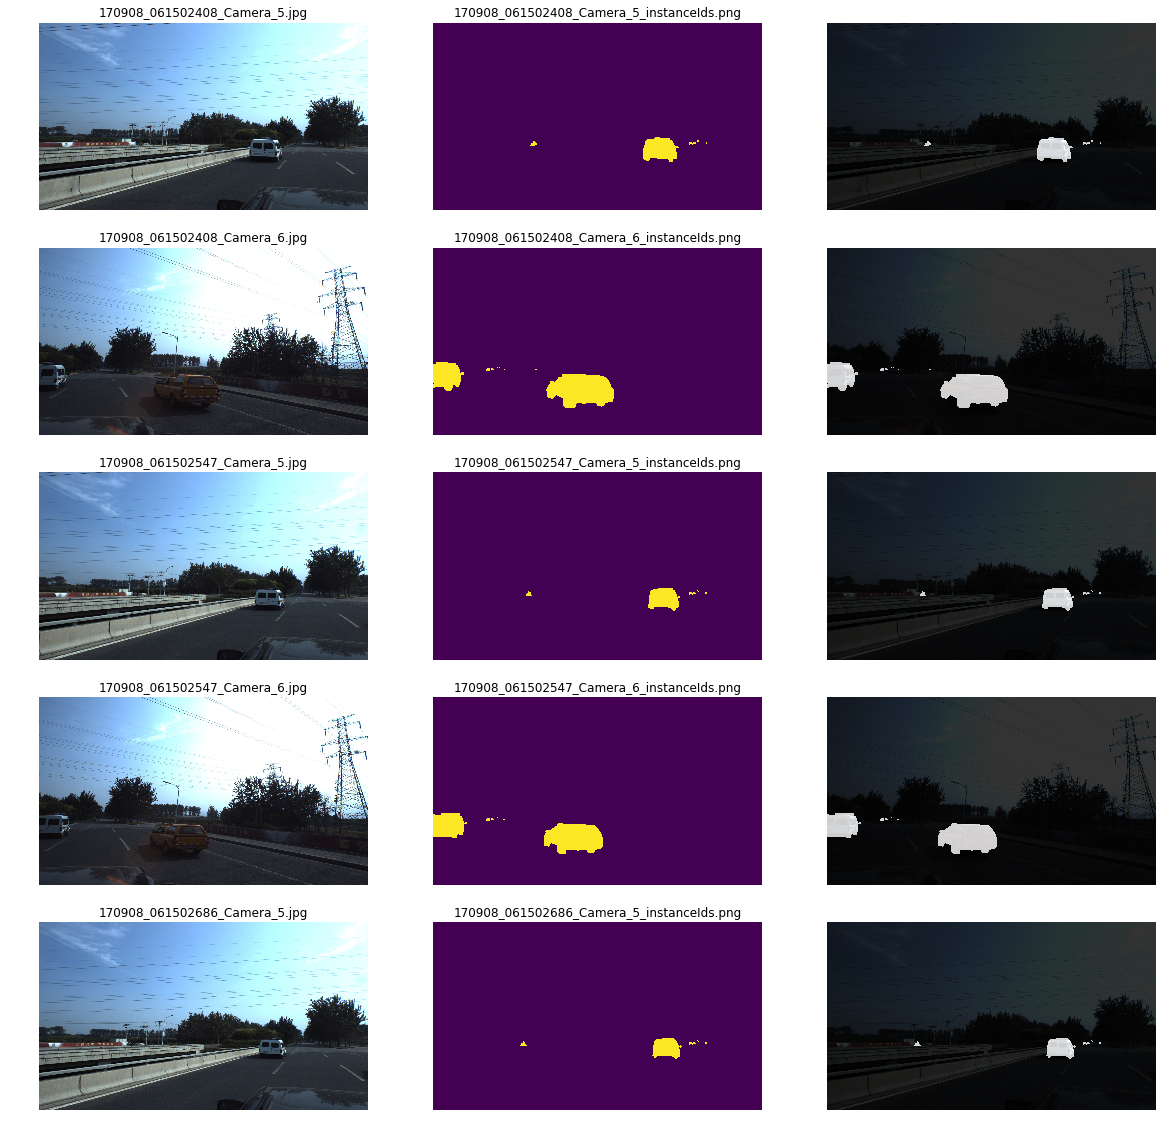

CPU times: user 7 s, sys: 456 ms, total: 7.46 s
Wall time: 7.01 s


In [13]:
%%time
batch = 300
f, ax = plt.subplots(5, 3, figsize=(20, 20))
for i in range(5):
    img = imread(os.path.join(train_color_folder, file_list_color[i+batch]))
    label = imread(os.path.join(train_label_folder, file_list_label[i+batch])) // 1000
    label[label!=0] = 255
    blended_image = Image.blend(Image.fromarray(img), Image.fromarray(label).convert('RGB'), alpha=0.8)
    
    ax[i, 0].imshow(img, aspect='auto')
    ax[i, 0].set_title(file_list_color[i])
    ax[i, 0].axis('off')
    ax[i, 1].imshow(label, aspect='auto')
    ax[i, 1].set_title(file_list_label[i])
    ax[i, 1].axis('off')
    ax[i, 2].imshow(blended_image, aspect='auto')
    ax[i, 2].axis('off')
plt.show()